# **Dementia Classification based on Linguistic Analysis**

Yunxi (Claire) Cheng, Tripti Sharma, Linting (Linsey) Wang, Sifan(Ellen) Zhu

# **Project Overview**

Our goal is to classify ***if a patient has dementia /Alzheimers based on linguistic data from the DementiaBank dataset***. The label is a binary value indicating if the patient has dementia (1) or not (0). The predictor is the transcripts with audio data containing sentences from patients with or without dementia. 


# **Motivation & Novelty**

Dementia is a debilitating neurological disorder that affects millions of people worldwide. Early diagnosis and intervention can significantly improve patients' quality of life, but it can be challenging to identify dementia in its early stages. Machine learning models can help to classify individuals with dementia based on language use patterns, which can serve as an early diagnostic tool.

Healthcare professionals, researchers, and caregivers who work with individuals with dementia would find such models useful. Implementing these models could improve the quality of care and treatment for individuals with dementia while also supporting research into the underlying mechanisms of the disease.


# **Data Source**

Dataset for this project is retrived from [**DementiaBank**](https://dementia.talkbank.org/).

The dataset contains audio recordings and transcriptions of conversations between individuals with dementia and no dementia as the control. Transcriptions were transcribed using CLAN (Computerized Language Analysis) software tool which provides a user-friendly interface for transcribing audio data and allows researchers to create coded transcripts for detailed linguistic analysis. In this project, the audio data from the DementiaBank corpus was transcribed using CLAN and then preprocessed for use in the neural network. The `.cha` files were obtained from TalkBank and preprocessed to remove irrelevant information and convert them to a format suitable for training a machine learning model. 

The basic motive behind the neural network and classification is to identify patterns in language use that are characteristic of individuals with dementia. The neural network uses the transcriptions of conversations between individuals with dementia and their caregivers to learn these patterns and classify individuals as either having dementia or not. By accurately classifying individuals with dementia, the model can serve as an early diagnostic tool, allowing for earlier intervention and improved outcomes for patients.



## Data cleaning

In [ ]:
# mount drive
from google.colab import drive
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import io
import numpy as np


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# check the version of tensorflow and upgrade if needed
!pip -q install --upgrade tensorflow 

Our first step of data cleaning is to import the data, and parse the `.cha` formatted data into strings by:
Removing unwanted lines from the investigator, which was also recorded along 

1.   Removing unwanted lines from the investigator. We kept speech opens with `*PAR:` which indicates that it is from the participants only.

2.   Removing the encoding that fails to retain any meaning when transformed from `.cha` file to strings using `re`. 

In [ ]:
import os
import re
import chardet

# parse .cha files to string
def parse_cha_file(content):
  parsed_data = []
  lines = content.split("\n")
  for line in lines:
    if line.startswith("*PAR:"): # keeps only participants' speech
      line = re.sub('\d+', '', line)
      line = re.sub('_', '', line)
      speaker = re.findall(r'\*(\w+):', line)[0]
      utterance = line.split(":", 1)[1].strip()
      
      """ Need to figure out a way to remove the number_number at the end of each line"""

      parsed_data.append({"speaker": speaker, "utterance": utterance})
  return parsed_data

# control folder
folder_path_cnt = '/content/drive/Shareddrives/Dementia Classification based on Linguistic Analysis/dementia/Control'
folder_path_dmt = '/content/drive/Shareddrives/Dementia Classification based on Linguistic Analysis/dementia/Dementia'

speech_data_cnt = []
speech_data_dmt = []

for file in os.listdir(folder_path_cnt):
  if file.endswith(".cha"):
    file_path = os.path.join(folder_path_cnt, file)
    speech = ""


    # Detect the file encoding using chardet
    with open(file_path, "rb") as f:
      file_content = f.read()
      detected_encoding = chardet.detect(file_content)["encoding"]
     
    # Read the file with the detected encoding
    with open(file_path, "r", encoding=detected_encoding) as f:
      content = f.read()

    parsed_data = parse_cha_file(content)

    for entry in parsed_data:
      speech += entry["utterance"]
      speech += " "
    speech_data_cnt.append([speech, 0])

for file in os.listdir(folder_path_dmt):
  if file.endswith(".cha"):
    file_path = os.path.join(folder_path_dmt, file)
    speech = ""

    # Detect the file encoding using chardet
    with open(file_path, "rb") as f:
      file_content = f.read()
      detected_encoding = chardet.detect(file_content)["encoding"]
     
    # Read the file with the detected encoding
    with open(file_path, "r", encoding=detected_encoding) as f:
      content = f.read()

    parsed_data = parse_cha_file(content)

    for entry in parsed_data:
      speech += entry["utterance"]
      speech += " "
    speech_data_dmt.append([speech, 1])

data = speech_data_dmt + speech_data_cnt

df = pd.DataFrame(data, columns=['speech', 'has_dementia'])
df.head(5)

## Data Description

The data consists of text samples in the `'speech'` column, and a binary label in the `'has_dementia'` column indicating whether the speaker has been diagnosed with dementia or not. 

The data has 1040 records of dementia patients, and 247 records of control with class imbalance.

In total, there are 1287 observations. 

In [ ]:
#check the total number of demential and control
len(speech_data_dmt),len(speech_data_cnt)

(1040, 247)

In [ ]:
# shuffle the rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head(5)

,speech,has_dementia
0,the boy is on a stool that is falling while he...,0
1,+< oh . [+ exc]  +< cat [/] cat . [+ exc] ...,1
2,I write with a pencil .  that was what ? [+ ...,1
3,this little girl <went to the> [//] &-uh went ...,1
4,hm . [+ exc]  xxx . [+ exc] this little boy ...,0


In [ ]:
print('total samples:',df.shape[0])
df_text = df['speech'].to_numpy()
labels = df["has_dementia"].to_numpy()
data_train = df_text[:800]
labels_train = labels[:800]
data_test = df_text[800:]
labels_test = labels[800:]

total samples: 1287


# **Neural Network Models** #

## LSTM Model without Embedding

The nature of the data suggests that our predictor consists of long strings, which makes LSTM (Long Short Term Memory) a good fit, as LSTM model is capable of dealing with long string of data.

We started by tokenizing and vectorizing the textual data.

In [ ]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, # We will use the 2000 most frequent terms; doing this automatically pads the                        sequences.
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
    #ragged=True, # This returns a ragged list (sequences of variable length); absent this, the vectorizer will pad. 
)
text_vectorization.adapt(df_text)

In [ ]:
processing = text_vectorization(data_train)
print(processing)

tf.Tensor(
[[  3  49   9 ...   0   0   0]
 [ 21   4   2 ...   0   0   0]
 [  6 180  52 ...   0   0   0]
 ...
 [  3   7 383 ...   0   0   0]
 [  3  31  49 ...   0   0   0]
 [  7 187   2 ...   0   0   0]], shape=(800, 666), dtype=int64)


Then we construct the model with 32 LSTMs. We also experimented with 16 and 64 LSTMs and found that 32 LSTMs gives the most accurate results. We also added `layers.Dropout(0.5)` to decrease overfitting, and used `activation="sigmoid"` in output layer because this is a classification prediction. 

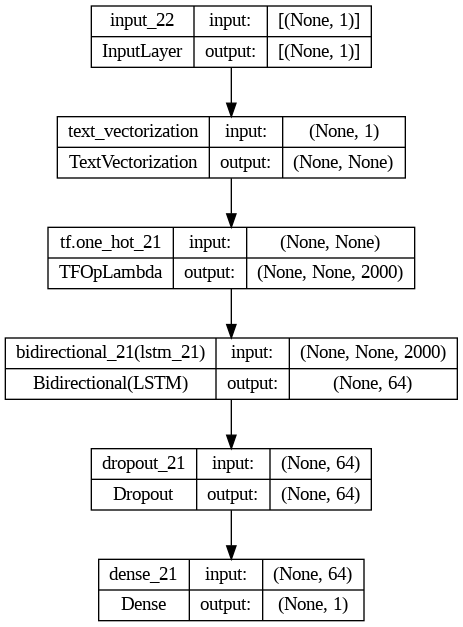

In [ ]:
def build_model():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    one_hot = tf.one_hot(processing, depth=2000) 
    x = layers.Bidirectional(layers.LSTM(32))(one_hot)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = build_model()

keras.utils.plot_model(model, show_shapes=True)
     


When fitting the model, we also used `EarlyStopping` to reduce overfitting. The results are accurate, with `- loss: 0.1751 - accuracy: 0.9450 - val_loss: 0.2275 - val_accuracy: 0.9076`.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 25
batch_sizes = 25

model = build_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(data_train, labels_train,
                        validation_data = (data_test,labels_test),  
                        epochs=num_epochs, batch_size=batch_sizes,callbacks=[early_stopping])
val_loss_history = history.history['val_loss']
val_acc_history = history.history['val_accuracy']
loss_history = history.history['loss']
acc_history = history.history['accuracy']

Epoch 1/25
32/32 [==============================] - 51s 1s/step - loss: 0.5060 - accuracy: 0.8100 - val_loss: 0.4517 - val_accuracy: 0.8008
Epoch 2/25
32/32 [==============================] - 42s 1s/step - loss: 0.3918 - accuracy: 0.8150 - val_loss: 0.3575 - val_accuracy: 0.8008
Epoch 3/25
32/32 [==============================] - 36s 1s/step - loss: 0.3176 - accuracy: 0.8350 - val_loss: 0.2878 - val_accuracy: 0.8583
Epoch 4/25
32/32 [==============================] - 39s 1s/step - loss: 0.2883 - accuracy: 0.8712 - val_loss: 0.2773 - val_accuracy: 0.8891
Epoch 5/25
32/32 [==============================] - 38s 1s/step - loss: 0.2768 - accuracy: 0.8737 - val_loss: 0.3706 - val_accuracy: 0.8357
Epoch 6/25
32/32 [==============================] - 39s 1s/step - loss: 0.2640 - accuracy: 0.8850 - val_loss: 0.2828 - val_accuracy: 0.8706
Epoch 7/25
32/32 [==============================] - 37s 1s/step - loss: 0.2321 - accuracy: 0.9062 - val_loss: 0.2586 - val_accuracy: 0.8727
Epoch 8/25
32/32 [==

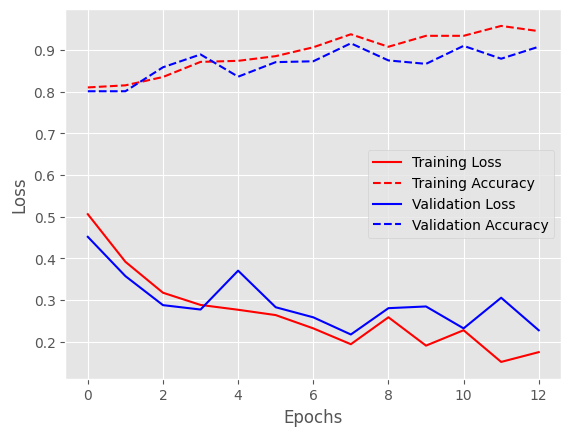

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.plot(loss_history,c='r')
plt.plot(acc_history,c="r",linestyle="dashed")
plt.plot(val_loss_history,c='b')
plt.plot(val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

16/16 [==============================] - 10s 518ms/step


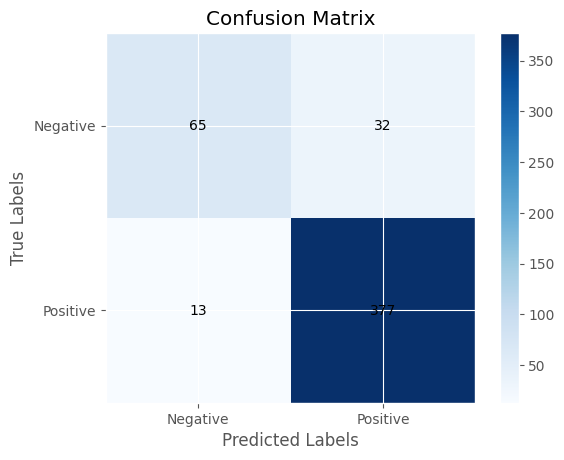

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(data_test)

# build confusion matrix
cm = confusion_matrix(labels_test, np.ravel(predictions)>0.5)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
# plot numbers in cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')

plt.show()

## Word Embedding with 1D Convolution

Our second model of choice is LSTM with word embedding layer. We added a 1D convolution layer. We then added a pooling layer along with the convolution layer, followed by the LSTM model.

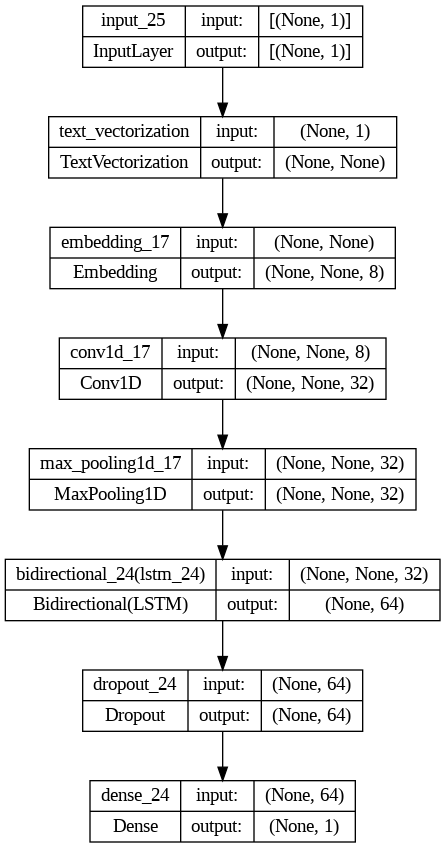

In [ ]:
def build_model_embed():
    inputs = keras.layers.Input(shape=(1), dtype="string") 
    processing = text_vectorization(inputs)
    one_hot = tf.one_hot(processing, depth=2000) 
    embedding = keras.layers.Embedding(input_dim=2000,output_dim=8,input_length=666, mask_zero=True)(processing)


    # Add a 1D convolutional layer
    conv_layer = keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedding)
    pool_layer = keras.layers.MaxPooling1D(pool_size=2)(conv_layer)

    # Add a bidirectional LSTM layer
    lstm_layer = layers.Bidirectional(layers.LSTM(32))(pool_layer)
    dropout_layer = layers.Dropout(0.5)(lstm_layer)
    outputs = layers.Dense(1, activation="sigmoid")(dropout_layer)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model


model = build_model_embed()

keras.utils.plot_model(model, show_shapes=True)

LSTM with word embedding layer results are: `- loss: 0.1038 - accuracy: 0.9638 - val_loss: 0.2412 - val_accuracy: 0.9117`. However, from the confusion matrix, we can see that there are more false positive predictions.

One possible explanation is that the participants are asked to read the same script, or describing the same picture; as a result, the word embedding or the context will not affect the predictions as much as the tokens themselves do.

In [ ]:
num_epochs = 25
batch_sizes = 25

model_embed = build_model_embed()
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model_embed.fit(data_train, labels_train,
                        validation_data = (data_test,labels_test),
                        epochs=num_epochs, batch_size=batch_sizes,callbacks=[early_stopping])
val_loss_history = history.history['val_loss']
val_acc_history = history.history['val_accuracy']
loss_history = history.history['loss']
acc_history = history.history['accuracy']

Epoch 1/25
32/32 [==============================] - 12s 167ms/step - loss: 0.5270 - accuracy: 0.7962 - val_loss: 0.4845 - val_accuracy: 0.8008
Epoch 2/25
32/32 [==============================] - 7s 210ms/step - loss: 0.4479 - accuracy: 0.8125 - val_loss: 0.3870 - val_accuracy: 0.8008
Epoch 3/25
32/32 [==============================] - 4s 132ms/step - loss: 0.3498 - accuracy: 0.8125 - val_loss: 0.3221 - val_accuracy: 0.8275
Epoch 4/25
32/32 [==============================] - 4s 133ms/step - loss: 0.3005 - accuracy: 0.8512 - val_loss: 0.2890 - val_accuracy: 0.8583
Epoch 5/25
32/32 [==============================] - 6s 199ms/step - loss: 0.2728 - accuracy: 0.8712 - val_loss: 0.2714 - val_accuracy: 0.8706
Epoch 6/25
32/32 [==============================] - 4s 134ms/step - loss: 0.2387 - accuracy: 0.8988 - val_loss: 0.2492 - val_accuracy: 0.8768
Epoch 7/25
32/32 [==============================] - 4s 131ms/step - loss: 0.2215 - accuracy: 0.9062 - val_loss: 0.2457 - val_accuracy: 0.9014
Epoch

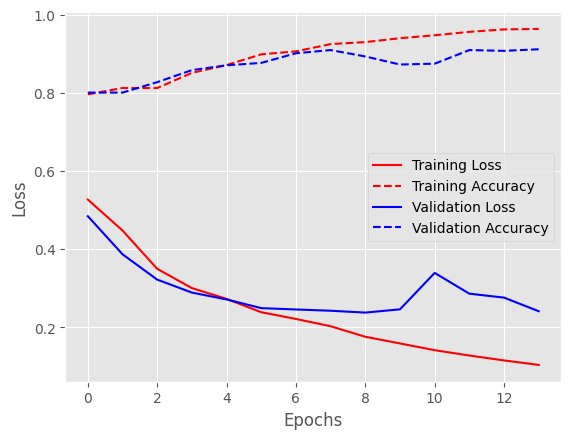

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.plot(loss_history,c='r')
plt.plot(acc_history,c="r",linestyle="dashed")
plt.plot(val_loss_history,c='b')
plt.plot(val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

16/16 [==============================] - 2s 51ms/step


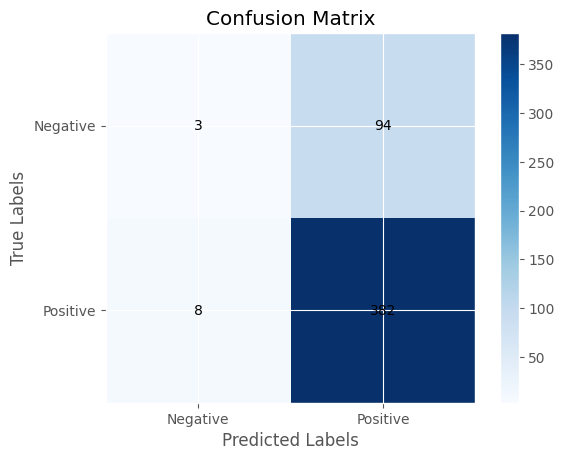

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(data_test)

# build confusion matrix
cm = confusion_matrix(labels_test, np.ravel(predictions)>0.5)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
# plot numbers in cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')

plt.show()

## Self-Attention Model

Our last model is the Attention Model, which is also capable of capturing and analyzing long sequence of data for predictions. We used 8-dimension embedding to transform the train data and applied dot product for the weights. 

In [ ]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, # This means we work with 2000 most common tokens.
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
    output_sequence_length = 666,
)

text_vectorization.adapt(df_text)

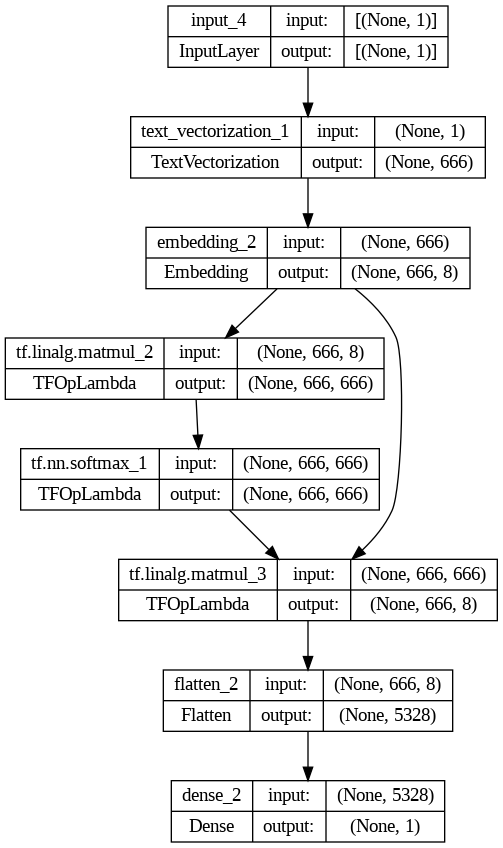

In [ ]:
def build_scaled_dotprod_model():
    inputs = keras.layers.Input(shape=(1,), dtype=tf.string) # We take a tensor of strings as input.
    integer_seqs = text_vectorization(inputs)

    # Our integer indices will be converted into 8-dimensional embeddings. 
    embeddings = layers.Embedding(2000,8)(integer_seqs)

    ### NOW LET'S BUILD THE ATTENTION MECHANISM
    
    # In Step 1, we need to compute pairwise dot-products between each word-embedding, and each other word embedding in the text sequence.
    # We have 666 word embeddings, so we should end up with 666 x 666 dot products.   
    pairwise_dot_products = tf.matmul(embeddings, embeddings, transpose_b=True)

    # In Step 2, we softmax the resulting dot products, yielding an element-wise transformation.
    # By specifying axis = -1 it means it softmaxes over the final axis of the tensor (rather than softmaxing over the entire tensor)
    # We'll end up with 666 * 666 scaled weights. 
    attention_weights = tf.nn.softmax(pairwise_dot_products, axis=-1)

    # Finally, in Step 3, in place of each input word embedding, we obtain the weighted sum of its peer-term attention_weights and those peer-term's input embeddings.  
    # Here, we are summing over terms (rather than over the embedding dimensions) 
    attention_output = tf.matmul(attention_weights, embeddings)

    # Flatten the attention output
    attention_output = layers.Flatten()(attention_output)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(attention_output)

    # Compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_scaled_dotprod_model()
keras.utils.plot_model(model,show_shapes=True)

Our results indicate that our attention model has the best performance: `- loss: 0.0879 - accuracy: 0.9725 - val_loss: 0.2149 - val_accuracy: 0.9220`. And it has the least overfitting comparing to the previous 2 models. Our confusion matrics also shows that with attention model, we get the highest numbers of true negative and true positives.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="dotprod.tf",
                                    save_best_only=True)
]

model = build_scaled_dotprod_model()
history = model.fit(data_train, labels_train, 
                        validation_data = (data_test,labels_test),
                        epochs=25, batch_size=25,callbacks=callbacks)

Epoch 1/25
32/32 [==============================] - ETA: 0s - loss: 0.5179 - accuracy: 0.7862

32/32 [==============================] - 14s 427ms/step - loss: 0.5179 - accuracy: 0.7862 - val_loss: 0.4867 - val_accuracy: 0.8008
Epoch 2/25
32/32 [==============================] - ETA: 0s - loss: 0.4598 - accuracy: 0.8125

32/32 [==============================] - 13s 407ms/step - loss: 0.4598 - accuracy: 0.8125 - val_loss: 0.4622 - val_accuracy: 0.8008
Epoch 3/25
32/32 [==============================] - ETA: 0s - loss: 0.4259 - accuracy: 0.8138

32/32 [==============================] - 13s 396ms/step - loss: 0.4259 - accuracy: 0.8138 - val_loss: 0.4171 - val_accuracy: 0.8008
Epoch 4/25
32/32 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.8200

32/32 [==============================] - 14s 459ms/step - loss: 0.3684 - accuracy: 0.8200 - val_loss: 0.3609 - val_accuracy: 0.8460
Epoch 5/25
32/32 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8425

32/32 [==============================] - 12s 379ms/step - loss: 0.3153 - accuracy: 0.8425 - val_loss: 0.3046 - val_accuracy: 0.8460
Epoch 6/25
32/32 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.8550

32/32 [==============================] - 12s 365ms/step - loss: 0.2792 - accuracy: 0.8550 - val_loss: 0.2879 - val_accuracy: 0.8480
Epoch 7/25
32/32 [==============================] - ETA: 0s - loss: 0.2576 - accuracy: 0.8763

32/32 [==============================] - 12s 371ms/step - loss: 0.2576 - accuracy: 0.8763 - val_loss: 0.2683 - val_accuracy: 0.8727
Epoch 8/25
32/32 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.8725

32/32 [==============================] - 12s 374ms/step - loss: 0.2442 - accuracy: 0.8725 - val_loss: 0.2601 - val_accuracy: 0.8789
Epoch 9/25
32/32 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.8925

32/32 [==============================] - 12s 380ms/step - loss: 0.2258 - accuracy: 0.8925 - val_loss: 0.2484 - val_accuracy: 0.8830
Epoch 10/25
32/32 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9137

32/32 [==============================] - 14s 434ms/step - loss: 0.2063 - accuracy: 0.9137 - val_loss: 0.2380 - val_accuracy: 0.8850
Epoch 11/25
32/32 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.9187

32/32 [==============================] - 12s 381ms/step - loss: 0.1968 - accuracy: 0.9187 - val_loss: 0.2296 - val_accuracy: 0.9055
Epoch 12/25
32/32 [==============================] - 10s 317ms/step - loss: 0.1775 - accuracy: 0.9325 - val_loss: 0.2699 - val_accuracy: 0.8542
Epoch 13/25
32/32 [==============================] - 11s 344ms/step - loss: 0.1744 - accuracy: 0.9325 - val_loss: 0.2304 - val_accuracy: 0.9014
Epoch 14/25
32/32 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9375

32/32 [==============================] - 12s 381ms/step - loss: 0.1658 - accuracy: 0.9375 - val_loss: 0.2229 - val_accuracy: 0.9097
Epoch 15/25
32/32 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9413

32/32 [==============================] - 13s 407ms/step - loss: 0.1556 - accuracy: 0.9413 - val_loss: 0.2136 - val_accuracy: 0.9138
Epoch 16/25
32/32 [==============================] - 11s 344ms/step - loss: 0.1455 - accuracy: 0.9500 - val_loss: 0.2166 - val_accuracy: 0.9097
Epoch 17/25
32/32 [==============================] - 10s 316ms/step - loss: 0.1324 - accuracy: 0.9600 - val_loss: 0.2154 - val_accuracy: 0.9076
Epoch 18/25
32/32 [==============================] - 11s 345ms/step - loss: 0.1371 - accuracy: 0.9538 - val_loss: 0.2576 - val_accuracy: 0.8891
Epoch 19/25
32/32 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9588

32/32 [==============================] - 13s 404ms/step - loss: 0.1208 - accuracy: 0.9588 - val_loss: 0.2098 - val_accuracy: 0.9179
Epoch 20/25
32/32 [==============================] - 11s 347ms/step - loss: 0.1171 - accuracy: 0.9588 - val_loss: 0.2272 - val_accuracy: 0.9035
Epoch 21/25
32/32 [==============================] - 13s 413ms/step - loss: 0.1047 - accuracy: 0.9675 - val_loss: 0.2107 - val_accuracy: 0.9240
Epoch 22/25
32/32 [==============================] - 10s 316ms/step - loss: 0.1140 - accuracy: 0.9513 - val_loss: 0.2150 - val_accuracy: 0.9158
Epoch 23/25
32/32 [==============================] - 10s 316ms/step - loss: 0.0988 - accuracy: 0.9613 - val_loss: 0.2227 - val_accuracy: 0.9076
Epoch 24/25
32/32 [==============================] - 11s 347ms/step - loss: 0.0931 - accuracy: 0.9675 - val_loss: 0.2225 - val_accuracy: 0.9117
Epoch 25/25
32/32 [==============================] - 11s 347ms/step - loss: 0.0879 - accuracy: 0.9725 - val_loss: 0.2149 - val_accuracy: 0.9220


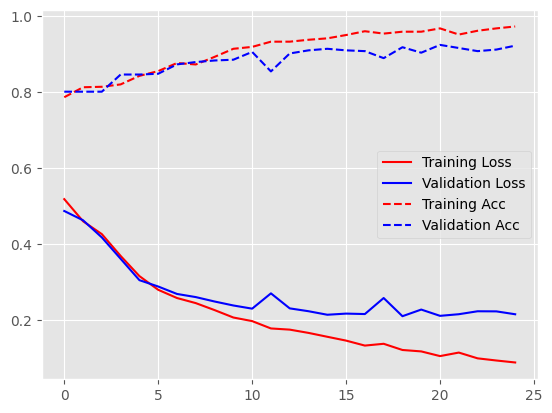

16/16 [==============================] - 2s 123ms/step - loss: 0.2098 - accuracy: 0.9179
Test acc: 0.918


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()

model = keras.models.load_model("dotprod.tf")
print(f"Test acc: {model.evaluate(data_test,labels_test)[1]:.3f}")

16/16 [==============================] - 3s 174ms/step


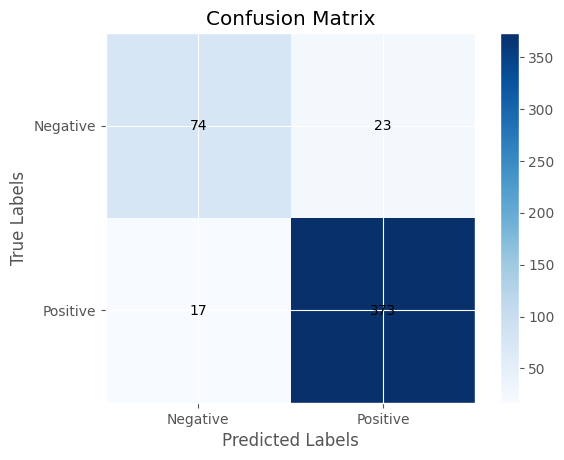

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(data_test)

# build confusion matrix
cm = confusion_matrix(labels_test, np.ravel(predictions)>0.5)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
# plot numbers in cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')

plt.show()

### Self-Attention Model with GloVe embeddings

We also try to use the GloVe pre-trained embeddings. however, it is overfitting very quickly. The origional attention model is better than attention mdoel with pre-trained embeddings here.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-05-02 02:53:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-02 02:53:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-02 02:53:58--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt" 
  
embeddings_index = {} 
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) # Split off only the first element in the row, i.e., the word, keep the remaining values as the vector.
        coefs = np.fromstring(coefs, "f", sep=" ") # Convert the set of numeric values into a numpy array, splitting elements by ' '
        embeddings_index[word] = coefs # Populate our dictionary - for this word (key), the vector representation is this vector (value).
  
glove_vec_lengths = len(coefs)

print(f"Found {len(embeddings_index)} word vectors.")
print(f"GloVe vector representations are {glove_vec_lengths} elements long.")
     

Found 400000 word vectors.
GloVe vector representations are 100 elements long.


In [ ]:
embedding_dim = glove_vec_lengths # The length of the vector representations; the latent embedding space will be in 100 dimensions. 

vocabulary = text_vectorization.get_vocabulary() # From the vocabulary our text vectorizer learned from our dataset, go over every word.
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Make a dictionary, key is word to value is index.

# Instantiate a matrix of values (these will be the 'weights' in our embedding layer)
embedding_matrix = np.zeros((len(vocabulary), embedding_dim)) # It will be the 2000 tokens by 100 (length of GloVe vectors)
for word, i in word_index.items():
    if i < len(vocabulary):
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.74746001, -0.36522999,  0.22048   , ..., -0.30627999,
         0.43299001,  0.015122  ],
       [ 0.040128  , -0.57393998,  0.17842001, ..., -0.0096184 ,
         0.90460998, -0.46077001],
       [ 0.87342   , -0.49823999,  0.18340001, ...,  0.089029  ,
        -0.025995  ,  0.014179  ]])

In [ ]:
embedding_layer = layers.Embedding(
    len(vocabulary), # 2000 words.
    glove_vec_lengths, # Vectors of 100 elements per word.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # Initialize with fixed values from our matrix.
    trainable=False, # These are weights, but they will be frozen so they don't update during training.
    mask_zero=True, # If we have a 0 token, for padding, we don't pass it through the layer.
)

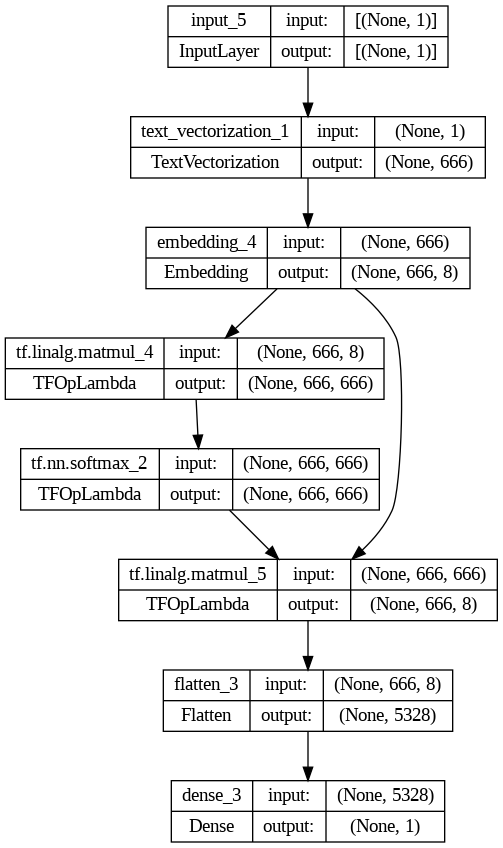

In [ ]:
def build_model_GloVe():
    inputs = keras.layers.Input(shape=(1,), dtype=tf.string) # We take a tensor of strings as input.
    integer_seqs = text_vectorization(inputs)

    # Our integer indices will be converted into 100-dimensional embeddings with GloVe. 
    embeddings = embedding_layer(integer_seqs) 
    pairwise_dot_products = tf.matmul(embeddings, embeddings, transpose_b=True)

    # In Step 2, we softmax the resulting dot products, yielding an element-wise transformation.
    # By specifying axis = -1 it means it softmaxes over the final axis of the tensor (rather than softmaxing over the entire tensor)
    # We'll end up with 666 * 666 scaled weights. 
    attention_weights = tf.nn.softmax(pairwise_dot_products, axis=-1)

    # Finally, in Step 3, in place of each input word embedding, we obtain the weighted sum of its peer-term attention_weights and those peer-term's input embeddings.  
    # Here, we are summing over terms (rather than over the embedding dimensions) 
    attention_output = tf.matmul(attention_weights, embeddings)

    # Flatten the attention output
    attention_output = layers.Flatten()(attention_output)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(attention_output)

    # Compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_scaled_dotprod_model()
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="dotprod.tf",
                                    save_best_only=True)
]

model = build_model_GloVe()
history = model.fit(data_train, labels_train, 
                        validation_data = (data_test,labels_test),
                        epochs=25, batch_size=25,callbacks=callbacks)

Epoch 1/25
32/32 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.7600

32/32 [==============================] - 14s 423ms/step - loss: 0.6491 - accuracy: 0.7600 - val_loss: 0.3523 - val_accuracy: 0.8419
Epoch 2/25
32/32 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.9162

32/32 [==============================] - 18s 583ms/step - loss: 0.2164 - accuracy: 0.9162 - val_loss: 0.3397 - val_accuracy: 0.8296
Epoch 3/25
32/32 [==============================] - 12s 380ms/step - loss: 0.1262 - accuracy: 0.9737 - val_loss: 0.3678 - val_accuracy: 0.8296
Epoch 4/25
32/32 [==============================] - 10s 317ms/step - loss: 0.0837 - accuracy: 0.9862 - val_loss: 0.3426 - val_accuracy: 0.8357
Epoch 5/25
32/32 [==============================] - 9s 275ms/step - loss: 0.0608 - accuracy: 0.9962 - val_loss: 0.3641 - val_accuracy: 0.8296
Epoch 6/25
32/32 [==============================] - 11s 365ms/step - loss: 0.0499 - accuracy: 0.9962 - val_loss: 0.3762 - val_accuracy: 0.8316
Epoch 7/25
32/32 [==============================] - 10s 326ms/step - loss: 0.0384 - accuracy: 0.9987 - val_loss: 0.3437 - val_accuracy: 0.8542
Epoch 8/25
32/32 [==============================] - 15s 480ms/step - loss: 0.0324 - accuracy: 1.0000 - val_loss: 0.3604 - val_accuracy: 0.8357
Epoch 9/25


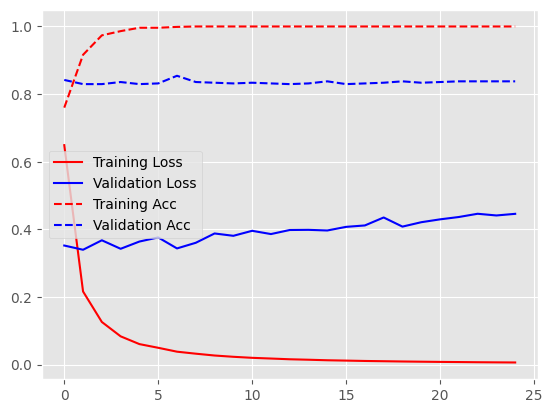

16/16 [==============================] - 5s 307ms/step - loss: 0.3397 - accuracy: 0.8296
Test acc: 0.830


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()

model = keras.models.load_model("dotprod.tf")
print(f"Test acc: {model.evaluate(data_test,labels_test)[1]:.3f}")

16/16 [==============================] - 6s 313ms/step


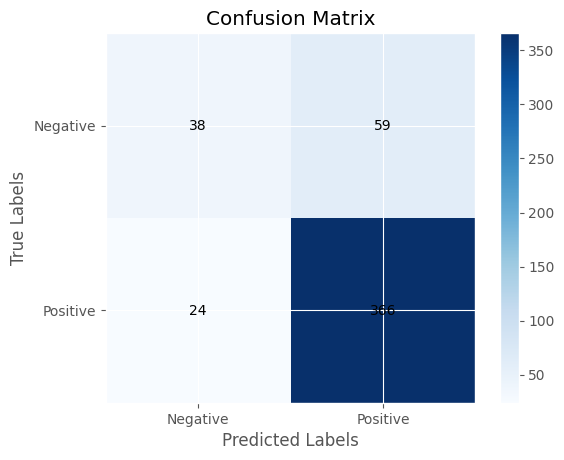

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(data_test)

# build confusion matrix
cm = confusion_matrix(labels_test, np.ravel(predictions)>0.5)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
# plot numbers in cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')

plt.show()

# **Results Comparison**
The results from the three models are as follows:


1.   ***LSTM without Embedding*** `- loss: 0.1751 - accuracy: 0.9450 - val_loss: 0.2275 - val_accuracy: 0.9076`.
2.   ***LSTM with 1D Convolution Layer for Embedding*** `- loss: 0.1038 - accuracy: 0.9638 - val_loss: 0.2412 - val_accuracy: 0.9117` but has more false positive predictions then the other two models.
3.   ***Attention model*** `- loss: 0.0879 - accuracy: 0.9725 - val_loss: 0.2149 - val_accuracy: 0.9220`, and have the highest number of true positives and true negative predicts.

As a result, we recommend using attention model for predicting dementia with the DementiaBank dataset. It is the most accurate in predicting if patients have dementia or not out of the 3 models we used. It is also the best choice for healthcare providers to better allocate resource and give patients the correct treatment they need.




# **Conclusion and Future Work**




The dementia classification model can be employed in real-life settings to assist medical professionals in accurately identifying patients with dementia. Its potential uses may include:

* *Early detection of dementia*: The model can be used to identify patients with 
early stages of dementia, even before the onset of symptoms. This can enable healthcare providers to initiate early interventions and treatments, which can help slow down the progression of the disease.

* *Improving accuracy of diagnosis*: The model can serve as a complementary tool to assist medical professionals in making accurate diagnosis of dementia. This can help reduce the number of misdiagnosed cases, and provide a more reliable and accurate diagnosis.

* *Streamlining diagnostic process*: The model can help streamline the diagnostic process by automating certain aspects of the diagnosis. This can help reduce the workload of healthcare providers, and also save time and resources.

* *Remote screening*: The model can also be used for remote screening of patients, especially in rural or remote areas where access to healthcare providers may be limited. This can help increase access to diagnosis and treatment for patients with dementia


To further enhance the developed dementia classification model, future research could explore various approaches, such as

* Expand the training dataset by integrating speech data collected from everyday dialogues.

* Future research on the dementia classification model could investigate the feasibility of utilizing audio data to eliminate the necessity of CLAN software training, and supplement the existing speech training data with additional samples obtained from everyday discourse.

* One potential area for future work is to leverage the developed model to classify different stages of dementia. This could involve incorporating additional data and features related to the progression of the disease, as well as exploring different neural network architectures and training techniques to optimize the model's performance in this specific task. By accurately identifying the stage of dementia, medical professionals can better tailor treatments and care plans to the needs of individual patients, potentially improving outcomes and quality of life.

